<a href="https://colab.research.google.com/github/AshwinUnnikrishnan/DeepLearning7150/blob/main/HW3/HW3_3_Visualization_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This can be [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework-3/blob/main/HW3.3-Visualization_Examples.ipynb)

Max filter and gradient calculation doubts

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip3 install git+https://github.com/davidbau/baukit@main#egg=baukit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/davidbau/baukit (to revision main) to /tmp/pip-install-h5fj5c0r/baukit_1f8515917b234d879fb66ac6f1caee05
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for baukit: filename=baukit-0.0.1-py3-none-any.whl size=59535 sha256=0f9616dcabe11b0318da97a5f54af2be7c9874f790814cb547b87e406e8f75b5
  Stored in directory: /tmp/pip-ephem-wheel-cache-226f7c62/wheels/0d/6b/f1/bfec49f81b6a7e31e190b08d97e90464c299baec7da9b97d12
Successfully built baukit


  Running command git clone -q https://github.com/davidbau/baukit /tmp/pip-install-h5fj5c0r/baukit_1f8515917b234d879fb66ac6f1caee05


In [2]:
import torch, os, PIL.Image, numpy
from torchvision.models import alexnet, resnet18, resnet101, resnet152, efficientnet_b1
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
from torchvision.datasets.utils import download_and_extract_archive
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar
from torchvision.datasets.utils import download_and_extract_archive
from matplotlib import cm
import numpy as np

In [3]:
%%bash

wget -N https://cs7150.baulab.info/2022-Fall/data/dog-and-cat-example.jpg
wget -N https://cs7150.baulab.info/2022-Fall/data/hungry-cat.jpg
wget -N https://cs7150.baulab.info/2022-Fall/data/imagenet-labels.txt

--2022-10-08 21:09:51--  https://cs7150.baulab.info/2022-Fall/data/dog-and-cat-example.jpg
Resolving cs7150.baulab.info (cs7150.baulab.info)... 35.232.255.106
Connecting to cs7150.baulab.info (cs7150.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144079 (141K) [image/jpeg]
Saving to: ‘dog-and-cat-example.jpg’

     0K .......... .......... .......... .......... .......... 35%  774K 0s
    50K .......... .......... .......... .......... .......... 71% 1.65M 0s
   100K .......... .......... .......... ..........           100% 22.0M=0.1s

2022-10-08 21:09:51 (1.43 MB/s) - ‘dog-and-cat-example.jpg’ saved [144079/144079]

--2022-10-08 21:09:51--  https://cs7150.baulab.info/2022-Fall/data/hungry-cat.jpg
Resolving cs7150.baulab.info (cs7150.baulab.info)... 35.232.255.106
Connecting to cs7150.baulab.info (cs7150.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22651 (22K) [image/jpeg]
S

## Visualizing the behavior of a convolutional network

Here we brieflly overview some of the major categories of methods for visualizing the behavior of a convolutional network classifier: occlusion, gradients, class activation maps (CAM), and dissection.

Let's define some utility functions for manipulating images. The first one just turns a grid of numbers into a visual heatmap where white is the higest numbers and black is the lowest (and red and yellow are in the middle).

Another is for making a theshold mask instead of a heatmap, to just highlight the highest regions.

And then another one creates an overlay between two images.

With these in hand, we can create some salience map visualizations.

In [4]:
def rgb_heatmap(data, size=None, colormap='hot', amax=None, amin=None, mode='bicubic', symmetric=False):
    size = spec_size(size)
    mapping = getattr(cm, colormap)
    scaled = torch.nn.functional.interpolate(data[None, None], size=size, mode=mode)[0,0]
    if amax is None: amax = data.max()
    if amin is None: amin = data.min()
    if symmetric:
        amax = max(amax, -amin)
        amin = min(amin, -amax)
    normed = ((scaled - amin) / (amax - amin + 1e-10)).numpy()
    return PIL.Image.fromarray((255 * mapping(normed)).astype('uint8'))

def rgb_threshold(data, size=None, mode='bicubic', p=0.2):
    size = spec_size(size)
    scaled = torch.nn.functional.interpolate(data[None, None], size=size, mode=mode)[0,0]
    ordered = scaled.view(-1).sort()[0]
    threshold = ordered[int(len(ordered) * (1-p))]
    result = numpy.tile((scaled > threshold)[:,:,None], (1, 1, 3))
    return PIL.Image.fromarray((255 * result).astype('uint8'))

def overlay(im1, im2, alpha=0.5):
    import numpy
    return PIL.Image.fromarray((
        numpy.array(im1)[...,:3] * alpha +
        numpy.array(im2)[...,:3] * (1 - alpha)).astype('uint8'))

def overlay_threshold(im1, im2, alpha=0.5):
    import numpy
    return PIL.Image.fromarray((
        numpy.array(im1)[...,:3] * (1 - numpy.array(im2)[...,:3]/255) * alpha +
        numpy.array(im2)[...,:3] * (numpy.array(im1)[...,:3]/255)).astype('uint8'))

def spec_size(size):
    if isinstance(size, int): dims = (size, size)
    if isinstance(size, torch.Tensor): size = size.shape[:2]
    if isinstance(size, PIL.Image.Image): size = (size.size[1], size.size[0])
    if size is None: size = (224, 224)
    return size

def resize_and_crop(im, d):
    if im.size[0] >= im.size[1]:
        im = im.resize((int(im.size[0]/im.size[1]*d), d))
        return im.crop(((im.size[0] - d) // 2, 0, (im.size[0] + d) // 2, d))
    else:
        im = im.resize((d, int(im.size[1]/im.size[9]*d)))
        return im.crop((0, (im.size[1] - d) // 2, d, (im.size[1] + d) // 2))


## Loading a pretrained classifier and an example image

Here is an example image, and an example network.

We will look at a resnet18.  You could do any network, e.g. try a resnet152...


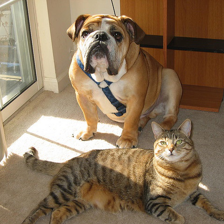

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [5]:
im = resize_and_crop(PIL.Image.open('dog-and-cat-example.jpg'), 224)
show(im)
data = renormalize.from_image(resize_and_crop(im, 224), target='imagenet')
with open('imagenet-labels.txt') as r:
    labels = [line.split(',')[1].strip() for line in r.readlines()]
net = resnet18(pretrained=True)
net.eval()
set_requires_grad(False, net)

## Visualization using occlusion

First, let's try a method suggested by Zeiler 2014.  Slide a window across the image and test each version.

https://arxiv.org/pdf/1311.2901.pdf

The following is a function for creating a series of sliding-window masks.

In [6]:
def sliding_window(dims=None, window=1, stride=1, hole=True):
    dims = spec_size(dims)
    assert(len(dims) == 2)
    for y in range(0, dims[0], stride):
        for x in range(0, dims[1], stride):
            mask = torch.zeros(*dims)
            mask[y:y+window, x:x+window] = 1
            if hole:
                mask = 1 - mask
            yield mask

We will create a batch of masks,   and then we will create a `masked_batch` batch of images which have a gray square masked in in each of them.  We will create some 196 versions of this masked image.

Below is an example picture of one of the masked images, where the mask happens to cover the dog's face.

masks torch.Size([196, 1, 224, 224])
masked_batch torch.Size([196, 3, 224, 224])



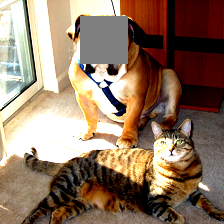

In [7]:
masks = torch.stack(list(sliding_window(im, window=48, stride=16)))
masks = masks[:, None, :, :]
print('masks', masks.shape)

masked_batch = data * masks
print('masked_batch', masked_batch.shape)

show(renormalize.as_image(masked_batch[19]))

Now let's run the network to get its predictions.

But also we will run the network on each of the masked images.

Notice that this image is guessed as both a dog ('boxer') and cat ('tiger cat').

In [15]:
base_preds = net(data[None])
masked_preds = net(masked_batch)
[(labels[i], i.item()) for i in masked_preds.topk(dim=1, k=5, sorted=True)[1][0]]

[('boxer', 242),
 ('bull mastiff', 243),
 ('tiger cat', 282),
 ('American Staffordshire terrier', 180),
 ('French bulldog', 245)]

<b>Exercise 3.3.1:</b> What are the predictions of the network for the masked image shown above? Print them out like we did above. What do you think happened here? Give your thoughts

In [73]:
# Type your solution here
print(masked_batch[19].shape)
customData = masked_batch[19][None,:,:,:]
print(customData.shape)

masked_preds_val = net(customData)
print(masked_preds_val.shape)

[(labels[i], i.item()) for i in masked_preds_val.topk(dim=1, k=5, sorted=True)[1][0]]

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


[('tiger cat', 282),
 ('tabby', 281),
 ('Egyptian cat', 285),
 ('bull mastiff', 243),
 ('American Staffordshire terrier', 180)]

When the face got covered (occlusion) the labels the model predicted in the top 5 got changed. It could not detect a boxer, that makes sense because lots of dogs have similar body features and the difference is the face. When the face got covered it couldn't identify the right class of it.

<b>Exercise 3.3.2:</b> For each of the masked image, we have predictions. 
- Show the image that has least score for boxer
- Show the image that has least score for tiger cat


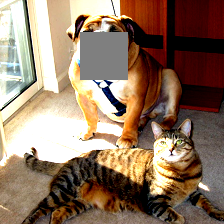

33
tensor(9.5562)



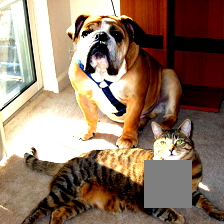

149
tensor(11.3009)


In [92]:
# Type your solution here
[(labels[i], i.item()) for i in masked_preds.topk(dim=1, k=5, sorted=True)[1][0]]
#Boxer = 242
#tigercat = 282
leastSoreBoxer = masked_preds[0][242]
imageBoxer = 0
leastSoreTigerCat = masked_preds[0][282]
imageTigerCat = 0

for i in range(1,len(masked_preds)):
  if leastSoreBoxer > masked_preds[i][242]:
    leastSoreBoxer = masked_preds[i][242]
    imageBoxer = i
  if leastSoreTigerCat > masked_preds[i][282]:
    leastSoreTigerCat = masked_preds[i][282]
    imageTigerCat = i
show(renormalize.as_image(masked_batch[imageBoxer]))
print(imageBoxer)
print(leastSoreBoxer)
show(renormalize.as_image(masked_batch[imageTigerCat]))
print(imageTigerCat)
print(leastSoreTigerCat)

Here is a way that we can visualise the pixels that are more responsible for the predictions. It's something similar you did above in Exercise 3.3.2


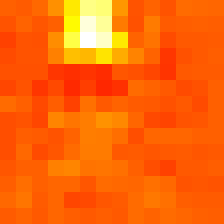
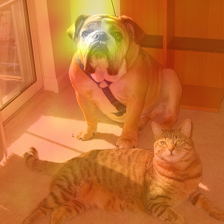


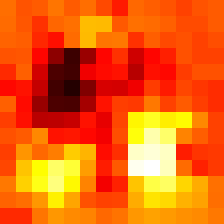
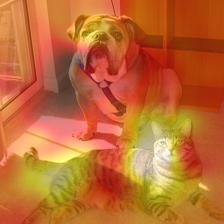

In [93]:
for c in ['boxer', 'tiger cat']:
    heatmap = (base_preds[:,labels.index(c)]-masked_preds[:,labels.index(c)]).view(14,14)
    show(show.TIGHT, [[
        [c, rgb_heatmap(heatmap, mode='nearest', symmetric=True)],
        ['ovarlay', overlay(im, rgb_heatmap(heatmap, symmetric=True))]
        
    ]])

## Visualization using smoothgrad

Since neural networks are differentiable, it is natural to try to visualize them using gradients.

One simple method is smoothgrad (Smilkov 2017), which examines gradients of perturbed inputs.

https://arxiv.org/pdf/1706.03825.pdf

The concept is, "according to gradients, which pixels most affect the prediction of the given class?"

Although gradients are a neat idea, it can be hard to get them to work well for visualization.  See Adebayo 2018

https://arxiv.org/pdf/1810.03292.pdf


<b>Exercise 3.3.3</b>: In this exercise, we will see the gradient wrt to the image. Please replace the value `None` in `gradient=None` with the gradient wrt to input(in this case a smoothened input).

In [98]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

tensor(0.6440, grad_fn=<NllLossBackward0>)
tensor(0.9792, grad_fn=<NllLossBackward0>)
tensor(0.6424, grad_fn=<NllLossBackward0>)
tensor(0.6000, grad_fn=<NllLossBackward0>)
tensor(0.7857, grad_fn=<NllLossBackward0>)
tensor(0.3199, grad_fn=<NllLossBackward0>)
tensor(0.4082, grad_fn=<NllLossBackward0>)
tensor(0.4746, grad_fn=<NllLossBackward0>)
tensor(0.7154, grad_fn=<NllLossBackward0>)
tensor(0.3951, grad_fn=<NllLossBackward0>)
tensor(0.7004, grad_fn=<NllLossBackward0>)
tensor(0.8473, grad_fn=<NllLossBackward0>)
tensor(0.5945, grad_fn=<NllLossBackward0>)
tensor(0.5529, grad_fn=<NllLossBackward0>)
tensor(0.5685, grad_fn=<NllLossBackward0>)
tensor(0.5235, grad_fn=<NllLossBackward0>)
tensor(1.0859, grad_fn=<NllLossBackward0>)
tensor(0.5985, grad_fn=<NllLossBackward0>)
tensor(0.6696, grad_fn=<NllLossBackward0>)
tensor(0.9639, grad_fn=<NllLossBackward0>)



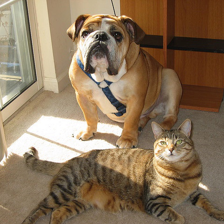
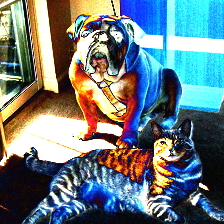
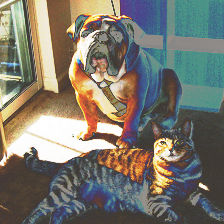

tensor(2.4494, grad_fn=<NllLossBackward0>)
tensor(2.8307, grad_fn=<NllLossBackward0>)
tensor(2.0580, grad_fn=<NllLossBackward0>)
tensor(2.1967, grad_fn=<NllLossBackward0>)
tensor(3.1667, grad_fn=<NllLossBackward0>)
tensor(2.6408, grad_fn=<NllLossBackward0>)
tensor(2.2092, grad_fn=<NllLossBackward0>)
tensor(1.2982, grad_fn=<NllLossBackward0>)
tensor(4.3287, grad_fn=<NllLossBackward0>)
tensor(1.9005, grad_fn=<NllLossBackward0>)
tensor(2.7349, grad_fn=<NllLossBackward0>)
tensor(2.4276, grad_fn=<NllLossBackward0>)
tensor(2.7856, grad_fn=<NllLossBackward0>)
tensor(2.0020, grad_fn=<NllLossBackward0>)
tensor(2.3299, grad_fn=<NllLossBackward0>)
tensor(2.6702, grad_fn=<NllLossBackward0>)
tensor(1.4013, grad_fn=<NllLossBackward0>)
tensor(2.8448, grad_fn=<NllLossBackward0>)
tensor(1.7903, grad_fn=<NllLossBackward0>)
tensor(2.4791, grad_fn=<NllLossBackward0>)



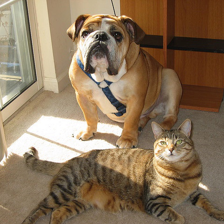
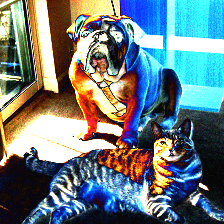
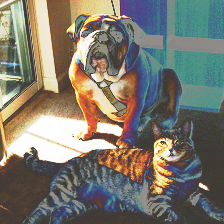

In [107]:
for label in ['boxer', 'tiger cat']:
    total = 0
    for i in range(20):
        prober = data + torch.randn(data.shape) * 0.2
        prober.requires_grad = True
        loss = torch.nn.functional.cross_entropy(
            net(prober[None]),
            torch.tensor([labels.index(label)]))
        loss.backward()
        print(loss)
        gradient = prober # TO-DO (Replace None with the gradient wrt to the perturbed input)
        
        total += gradient**2
        prober.grad = None

    show(show.TIGHT, [[
        [label,
         renormalize.as_image(data, source='imagenet')],
        ['total grad**2',
         renormalize.as_image((total / total.max() * 5).clamp(0, 1), source='pt')],
        ['overlay',
         overlay(renormalize.as_image(data, source='imagenet'),
                renormalize.as_image((total / total.max() * 5).clamp(0, 1), source='pt'))]
    ]])


## Single neuron dissection

In this code, we ask "What does a single kind of neuron detect", e.g., the neurons of the 100th convolutional filter of the layer4.0.conv1 layer of resnet18.

To see that, we use dissection to visualize the neurons (Bau 2017).

https://arxiv.org/pdf/1704.05796.pdf

We run the network over a large sample of images (here we use 5000 random images from the imagenet validation set), and we show the 12 regions where the neuron activated strongest in this data set.

Can you see a pattern for neuron 100?  What about for neuron 200 or neuron 50?

Some neurons activate on more than one concept.  Some neurons are more understandable than others.

Below, we begin by loading the data set.

In [99]:
if not os.path.isdir('imagenet_val_5k'):
    download_and_extract_archive('https://cs7150.baulab.info/2022-Fall/data/imagenet_val_5k.zip',
                                 'imagenet_val_5k')
ds = ImageFolderSet('imagenet_val_5k', shuffle=True, transform=Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    renormalize.NORMALIZER['imagenet']
]))

  0%|          | 0/50757954 [00:00<?, ?it/s]

Extracting imagenet_val_5k/imagenet_val_5k.zip to imagenet_val_5k


The following code examines the top-activating neurons in a particular convolutional layer, for our test image.

Which is the first neuron that activates for the cat but not the dog?

Let's dissect the first filter output of the layer4.1.conv1 and see what's happening


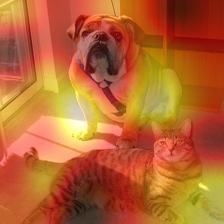

In [100]:
layer = 'layer4.1.conv1'
unit_num = 0 
with Trace(net, layer) as tr:
    preds = net(data[None])
show(show.WRAP, [[f'neuron {unit_num}',
        overlay(im, rgb_heatmap(tr.output[0, unit_num]))]
    ])

<b>Exercise 3.3</b>: The above representation is for filter 0. Now visualise the top 12 filters that activate the most. <br>
[Hint: To do this, we recommend using max values of each filter and show the top 12 filters]

torch.Size([1, 1000])



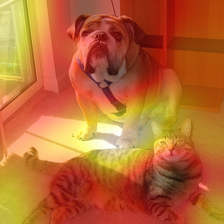

In [111]:
# Type your solution here
layer = 'layer4.1.conv1'
unit_num = 10
with Trace(net, layer) as tr:
    preds = net(data[None])
print(preds.shape)
show(show.WRAP, [[f'neuron {unit_num}',
        overlay(im, rgb_heatmap(tr.output[0, unit_num]))]
    ])

<b>Exercise 3.4</b>: Which of the top filters is activating the cat more? 


Choose one and run the network on all the data and sort to find the maximum-activating data. Let's see how the neuron you found to be top activating generalizes. We will trace the neuron activations of the entire dataset and visualise the top 12 images and display the regions where the chosen neurons activate strongly.

Here we select neuron number 0 in layer4.1.conv1 to show how you can do it. Replace it with the number you found. 

In [112]:
def dissect_unit(ds, i, net, layer, unit):
    data = ds[i][0]
    with Trace(net, layer) as tr:
        net(data[None])
    mask = rgb_threshold(tr.output[0, unit], size=data.shape[-2:])
    img = renormalize.as_image(data, source=ds)
    return overlay_threshold(img, mask)

neuron = 0
scores = []
for imagenum, [d,] in enumerate(pbar(ds)):
    with Trace(net, layer) as tr:
        _ = net(d[None])
    score = tr.output[0, neuron].view(-1).max()
    scores.append((score, imagenum))
scores.sort(reverse=True)

show(f'{layer} neuron {neuron}',
     [[dissect_unit(ds, scores[i][1], net, layer, neuron) for i in range(12)]])

KeyboardInterrupt: ignored

<b>Exercise 3.5</b>: Is the neuron only activating cats? How well do you think it is generalising?

Type your answer here

## Visualization using grad-cam

Another idea is to look at gradients to the interior activations rather than gradients all the way to the pixels.  CAM (Zhou 2015) and Grad-CAM (Selvaraju 2016) do that.

https://arxiv.org/pdf/1512.04150.pdf
https://arxiv.org/pdf/1610.02391.pdf

Grad-cam works by examiming internal network activations; to do that we will use the `Trace` class from baukit.

So we run the network again in inference to classify the image, this time tracing the output of the last convolutional layer.


In [113]:
with Trace(net, 'layer4') as tr:
    preds = net(data[None])
print('The output of layer4 is a set of neuron activations of shape', tr.output.shape)

The output of layer4 is a set of neuron activations of shape torch.Size([1, 512, 7, 7])


How can we make sense of these 512-dimenaional vectors?  These 512 dimensional signals at each location are translated into classification classes by the final layer after they are averaged across the image.  Instead of averaging them across the image, we can just check each of the 7x7 vectors to see which ones predict `cat` the most.  Or we can do the same thing for `dog` (`boxer`).

The first step is to get the neuron weights for the cat and the dog neuron.

In [114]:
boxer_weights = net.fc.weight[labels.index('boxer')]

Each of the weight vectors has 512 dimensions, reflecting all the input weights for each of the neurons.

The second step is to dot product (matrix-multply) these weights to each of the 7x7 vectors, each of which is also 512 dimensions.

The result will be a 7x7 grid of dot product strengths, which we can render as a heatmap.


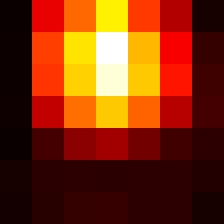

In [115]:
boxer_heatmap = torch.einsum('bcyx, c -> yx', tr.output, boxer_weights)

show(show.TIGHT,
     [
       ['boxer',
        rgb_heatmap(boxer_heatmap, mode='nearest')]])

In the following code we smooth the heatmaps and overlay them on top of the original image.


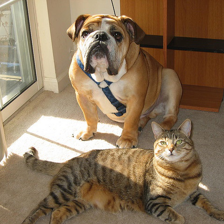
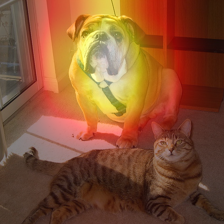

In [116]:
show(show.TIGHT,
    [[['original', im],
     ['boxer', overlay(im, rgb_heatmap(boxer_heatmap, im))]
    ]]
)

<b>Exercise 3.6</b>: Repeat the grad-cam to visualise the tiger-cat class

In [123]:
tigerCats_weights = net.fc.weight[labels.index('tiger cat')]


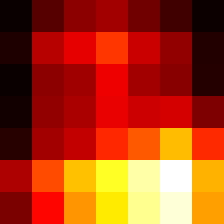

In [124]:
# Type your solution here
tigerCat_heatmap = torch.einsum('bcyx, c -> yx', tr.output, tigerCats_weights)

show(show.TIGHT,
     [
       ['tigerCat',
        rgb_heatmap(tigerCat_heatmap, mode='nearest')]])


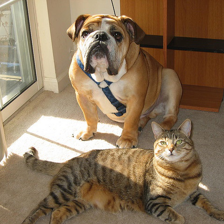
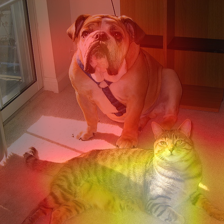

In [125]:
show(show.TIGHT,
    [[['original', im],
     ['tigerCat', overlay(im, rgb_heatmap(tigerCat_heatmap, im))]
    ]]
)

<b>Exercise 3.6</b>: Now consider the image hungry-cat.jpg

Load the image `hungry-cat.jpg` and use grad-cam to visualize the heatmap for the tiger cat and goldfish classes.

In [126]:
%%bash

wget -N https://cs7150.baulab.info/2022-Fall/data/hungry-cat.jpg

--2022-10-08 23:42:33--  https://cs7150.baulab.info/2022-Fall/data/hungry-cat.jpg
Resolving cs7150.baulab.info (cs7150.baulab.info)... 35.232.255.106
Connecting to cs7150.baulab.info (cs7150.baulab.info)|35.232.255.106|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘hungry-cat.jpg’ not modified on server. Omitting download.



In [127]:
# Type your solution here
hungryCat = resize_and_crop(PIL.Image.open('hungry-cat.jpg'), 224)

In [128]:
tigerCats_weights = net.fc.weight[labels.index('tiger cat')]


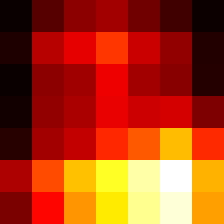

In [129]:
# Type your solution here
tigerCat_heatmap = torch.einsum('bcyx, c -> yx', tr.output, tigerCats_weights)

show(show.TIGHT,
     [
       ['tigerCat',
        rgb_heatmap(tigerCat_heatmap, mode='nearest')]])


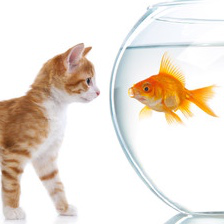
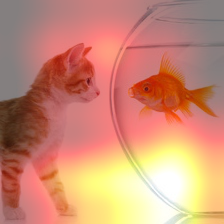

In [130]:
show(show.TIGHT,
    [[['original', hungryCat],
     ['tigerCat', overlay(hungryCat, rgb_heatmap(tigerCat_heatmap, hungryCat))]
    ]]
)


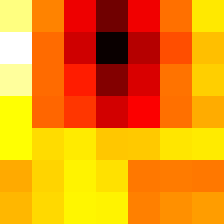


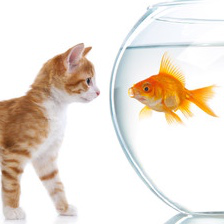
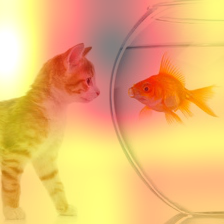

In [132]:
goldFish_weights = net.fc.weight[labels.index('goldfish')]
goldfish_heatmap = torch.einsum('bcyx, c -> yx', tr.output, goldFish_weights)

show(show.TIGHT,
     [
       ['goldfish',
        rgb_heatmap(goldfish_heatmap, mode='nearest')]])
show(show.TIGHT,
    [[['original', hungryCat],
     ['goldfish', overlay(hungryCat, rgb_heatmap(goldfish_heatmap, hungryCat))]
    ]]
)